In [1]:
#https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection. Converted class 'yes' 'no' class labels to 0,1.

In [2]:
import sys
import os
import skimage
from skimage import io
from skimage import transform
import numpy as np
import tensorflow as tf
print(tf.__version__)
import keras

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

1.13.0-rc1


Using TensorFlow backend.


In [3]:
#Load images
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".JPG")]
        for f in file_names:
            images.append(io.imread(f))
            labels.append(int(d))
    return images, labels
ROOT_PATH = ""
train_data_directory = os.path.join(ROOT_PATH, "brain_tumor_dataset/")

In [4]:
X, y = load_data(train_data_directory)

In [5]:
X=np.array(X)
y=np.array(y)
X = [transform.resize(image, (28,28)) for image in X]

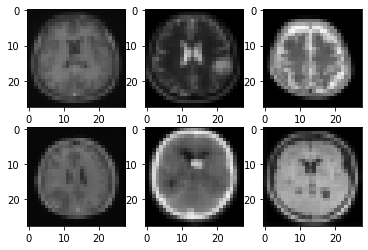

In [6]:
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = np.array(X_train)
X_test=np.array(X_test)
y_train = np.reshape(y_train,[y_train.shape[0],1])
y_test = np.reshape(y_test,[y_test.shape[0],1])
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

NUM_CLASSES = 2

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(input_shape=(28,28,3),padding="same",kernel_size=3,filters=16))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    
    model.add(Conv2D(padding="same",kernel_size=3,filters=32))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Conv2D(padding="same",kernel_size=3,filters=32))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    
    model.add(Conv2D(padding="same",kernel_size=3,filters=64))
    model.add(LeakyReLU(0.1))
    model.add(BatchNormalization())
    

    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(LeakyReLU(0.1))
    
    model.add(Activation("softmax"))
    
    model.add(Activation("softmax"))
    

   
    
    return model

In [9]:
from keras import backend as K
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10


# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    X_train, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    validation_data=(X_test, y_test2),
    shuffle=True,
    verbose=0
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Learning rate: 0.005
Learning rate: 0.0045
Learning rate: 0.00405
Learning rate: 0.003645
Learning rate: 0.0032805
Learning rate: 0.00295245
Learning rate: 0.002657205
Learning rate: 0.0023914846
Learning rate: 0.002152336
Learning rate: 0.0019371024


In [10]:
test_predictions = model.predict_proba(X_test).argmax(axis=-1)

In [11]:
test_answers = y_test2.argmax(axis=-1)

In [12]:
test_accuracy = np.mean(test_predictions==test_answers)


In [13]:
print(test_accuracy*100,'%')


88.0 %


In [14]:
model.save("model.h5")

In [15]:
del model


In [16]:
from keras import models    

model = models.load_model('model.h5')


In [17]:
test_predictions = model.predict_proba(X_test).argmax(axis=-1)

In [18]:
test_answers = y_test2.argmax(axis=-1)

In [68]:
test_accuracy = np.mean(test_predictions==test_answers)



In [19]:
print(test_accuracy*100,'%')



88.0 %


In [20]:
X_a = np.array([np.array(X_test[0])])
test_predictions = model.predict_proba(X_a).argmax(axis=-1)

In [21]:
test_answers = y_test2.argmax(axis=-1)

In [22]:
test_predictions[0]

1